<a href="https://colab.research.google.com/github/doo52oh/Dacon/blob/main/Energy_Usage/Energy_Usage_Baseline_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전력사용량 예측


## Columns
  1) num : 건물번호  
  2) date_time : 시간  
  3) 전력사용량 (kwh)  
  4) 기온  
  5) 풍속 (m/s)  
  6) 습도 (%)  
  7) 강수량 (mm)  
  8) 일조 (hr)  
  9) 비전기냉방설비운영  - 0,1  
  10) 태양광보유  - 0, 1


In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
train = pd.read_csv('train.csv', encoding='euc-kr', parse_dates=['date_time'])
test = pd.read_csv('test.csv', encoding='euc-kr', parse_dates=['date_time'])
submission = pd.read_csv('sample_submission.csv', encoding='euc-kr')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   num         122400 non-null  int64         
 1   date_time   122400 non-null  datetime64[ns]
 2   전력사용량(kWh)  122400 non-null  float64       
 3   기온(°C)      122400 non-null  float64       
 4   풍속(m/s)     122400 non-null  float64       
 5   습도(%)       122400 non-null  float64       
 6   강수량(mm)     122400 non-null  float64       
 7   일조(hr)      122400 non-null  float64       
 8   비전기냉방설비운영   122400 non-null  float64       
 9   태양광보유       122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


In [4]:
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   num           10080 non-null  int64         
 1   date_time     10080 non-null  datetime64[ns]
 2   기온(°C)        3360 non-null   float64       
 3   풍속(m/s)       3360 non-null   float64       
 4   습도(%)         3360 non-null   float64       
 5   강수량(mm, 6시간)  1680 non-null   float64       
 6   일조(hr, 3시간)   3360 non-null   float64       
 7   비전기냉방설비운영     2296 non-null   float64       
 8   태양광보유         1624 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 708.9 KB


In [5]:
train.isnull().sum().sum() # null 체크

0

In [6]:
test.isnull().sum().sum()

51520

In [7]:
test.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

In [8]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [9]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocess

In [10]:
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
train['hour'] = train['date_time'].dt.hour
train['min'] = train['date_time'].dt.minute
train['sec'] = train['date_time'].dt.second
train['day_of_week'] = train['date_time'].dt.dayofweek

In [11]:
test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day
test['hour'] = test['date_time'].dt.hour
test['min'] = test['date_time'].dt.minute
test['sec'] = test['date_time'].dt.second
test['day_of_week'] = test['date_time'].dt.dayofweek

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   num          122400 non-null  int64         
 1   date_time    122400 non-null  datetime64[ns]
 2   전력사용량(kWh)   122400 non-null  float64       
 3   기온(°C)       122400 non-null  float64       
 4   풍속(m/s)      122400 non-null  float64       
 5   습도(%)        122400 non-null  float64       
 6   강수량(mm)      122400 non-null  float64       
 7   일조(hr)       122400 non-null  float64       
 8   비전기냉방설비운영    122400 non-null  float64       
 9   태양광보유        122400 non-null  float64       
 10  year         122400 non-null  int64         
 11  month        122400 non-null  int64         
 12  day          122400 non-null  int64         
 13  hour         122400 non-null  int64         
 14  min          122400 non-null  int64         
 15  sec          122400 non-null  int6

In [39]:
def days_of_week (day):
  if   day == 0:
    return 'Mon'
  elif day == 1:
    return 'Tue'
  elif day == 2:
    return 'Wed'
  elif day == 3:
    return 'Thur'
  elif day == 4:
    return 'Fri'
  elif day == 5:
    return 'Sat'
  elif day == 6:
    return 'Sun'
  else:
    return 'err'


# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0


train['dow'] = train['day_of_week'].apply(days_of_week)
test['dow'] = test['day_of_week'].apply(days_of_week)

train['weekday'] = train['date_time'].apply(weekend)
train['weekend'] = train['date_time'].apply(weekend)
test['weekday'] = test['date_time'].apply(weekend)
test['weekend'] = test['date_time'].apply(weekend)

In [40]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,year,month,day,hour,min,sec,day_of_week,dow,weekday,불쾌지수,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020,6,1,0,0,0,0,Mon,0,63.43008,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020,6,1,1,0,0,0,Mon,0,63.56993,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,2,0,0,0,Mon,0,63.22775,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,3,0,0,0,Mon,0,62.54339,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020,6,1,4,0,0,0,Mon,0,62.39760,0


In [41]:
train[['day_of_week', 'dow']].head()

,day_of_week,dow
0,0,Mon
1,0,Mon
2,0,Mon
3,0,Mon
4,0,Mon


In [42]:
test[['day_of_week','dow']].head()

,day_of_week,dow
0,1,Tue
1,1,Tue
2,1,Tue
3,1,Tue
4,1,Tue


### Missing Value

In [43]:
building_info = train[['num','비전기냉방설비운영', '태양광보유']].drop_duplicates()
test.drop(columns=['비전기냉방설비운영', '태양광보유'], inplace = True)
test = pd.merge(test, building_info, on= 'num')

In [44]:
test.isnull().sum()

num             0
date_time       0
기온(°C)          0
풍속(m/s)         0
습도(%)           0
강수량(mm, 6시간)    0
일조(hr, 3시간)     0
year            0
month           0
day             0
hour            0
min             0
sec             0
day_of_week     0
dow             0
weekday         0
불쾌지수            0
weekend         0
비전기냉방설비운영       0
태양광보유           0
dtype: int64

In [45]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,year,month,day,hour,min,sec,day_of_week,dow,weekday,불쾌지수,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020,6,1,0,0,0,0,Mon,0,63.43008,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020,6,1,1,0,0,0,Mon,0,63.56993,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,2,0,0,0,Mon,0,63.22775,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,3,0,0,0,Mon,0,62.54339,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020,6,1,4,0,0,0,Mon,0,62.39760,0


In [46]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",year,month,day,hour,min,sec,day_of_week,dow,weekday,불쾌지수,weekend,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,2020,8,25,0,0,0,1,Tue,0,78.602280,0,0.0,0.0
1,1,2020-08-25 01:00:00,27.806027,1.366667,75.017358,0.0,0.0,2020,8,25,1,0,0,1,Tue,0,78.746152,0,0.0,0.0
2,1,2020-08-25 02:00:00,27.639360,1.233333,76.350691,0.0,0.0,2020,8,25,2,0,0,1,Tue,0,78.661547,0,0.0,0.0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,2020,8,25,3,0,0,1,Tue,0,78.340060,0,0.0,0.0
4,1,2020-08-25 04:00:00,26.787947,1.166667,79.965285,0.0,0.0,2020,8,25,4,0,0,1,Tue,0,77.770049,0,0.0,0.0


In [47]:
train['불쾌지수'] = 1.8*train['기온(°C)'] - 0.55*(1-(train['습도(%)']/100))*(1.8*train['기온(°C)']-26) + 32
test['불쾌지수'] = 1.8*test['기온(°C)'] - 0.55*(1-(test['습도(%)']/100))*(1.8*test['기온(°C)']-26) + 32

In [48]:
train['일조(hr)'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: 일조(hr), dtype: int64

In [49]:
test[['num','date_time','일조(hr, 3시간)']].head(25)

,num,date_time,"일조(hr, 3시간)"
0,1,2020-08-25 00:00:00,0.0
1,1,2020-08-25 01:00:00,0.0
2,1,2020-08-25 02:00:00,0.0
3,1,2020-08-25 03:00:00,0.0
4,1,2020-08-25 04:00:00,0.0
5,1,2020-08-25 05:00:00,0.0
6,1,2020-08-25 06:00:00,0.0
7,1,2020-08-25 07:00:00,0.0
8,1,2020-08-25 08:00:00,0.0
9,1,2020-08-25 09:00:00,1.1


In [50]:
test['일조(hr, 3시간)'] = test['일조(hr, 3시간)'].interpolate(method='pad')

In [51]:
test[['num','date_time','일조(hr, 3시간)']].head(25)

,num,date_time,"일조(hr, 3시간)"
0,1,2020-08-25 00:00:00,0.0
1,1,2020-08-25 01:00:00,0.0
2,1,2020-08-25 02:00:00,0.0
3,1,2020-08-25 03:00:00,0.0
4,1,2020-08-25 04:00:00,0.0
5,1,2020-08-25 05:00:00,0.0
6,1,2020-08-25 06:00:00,0.0
7,1,2020-08-25 07:00:00,0.0
8,1,2020-08-25 08:00:00,0.0
9,1,2020-08-25 09:00:00,1.1


In [52]:
test[['num','date_time','기온(°C)', '풍속(m/s)', '습도(%)']].head(24)

,num,date_time,기온(°C),풍속(m/s),습도(%)
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000
1,1,2020-08-25 01:00:00,27.806027,1.366667,75.017358
2,1,2020-08-25 02:00:00,27.639360,1.233333,76.350691
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000
4,1,2020-08-25 04:00:00,26.787947,1.166667,79.965285
5,1,2020-08-25 05:00:00,26.198116,1.233333,82.041681
6,1,2020-08-25 06:00:00,26.100000,1.300000,83.000000
7,1,2020-08-25 07:00:00,26.588515,1.266667,82.635378
8,1,2020-08-25 08:00:00,27.605279,1.233333,80.843668
9,1,2020-08-25 09:00:00,28.800000,1.200000,77.000000


In [53]:
train[['num','date_time','기온(°C)', '풍속(m/s)', '습도(%)']].head(24)

,num,date_time,기온(°C),풍속(m/s),습도(%)
0,1,2020-06-01 00:00:00,17.6,2.5,92.0
1,1,2020-06-01 01:00:00,17.7,2.9,91.0
2,1,2020-06-01 02:00:00,17.5,3.2,91.0
3,1,2020-06-01 03:00:00,17.1,3.2,91.0
4,1,2020-06-01 04:00:00,17.0,3.3,92.0
5,1,2020-06-01 05:00:00,16.9,3.4,93.0
6,1,2020-06-01 06:00:00,16.7,3.4,90.0
7,1,2020-06-01 07:00:00,16.9,2.3,86.0
8,1,2020-06-01 08:00:00,17.8,3.3,80.0
9,1,2020-06-01 09:00:00,19.3,2.1,73.0


In [54]:
num_1 = train.loc[train['num'] == 1]
num_1_day_1 = num_1.loc[num_1['day'] == 1]
num_1_j_1 = num_1_day_1.loc[num_1_day_1['month'] == 6]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0, flags=flags)


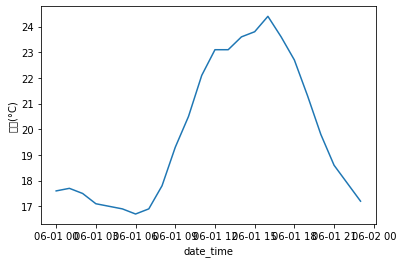

In [55]:
sns.lineplot(data = num_1_j_1, x = 'date_time', y = '기온(°C)')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0, flags=flags)


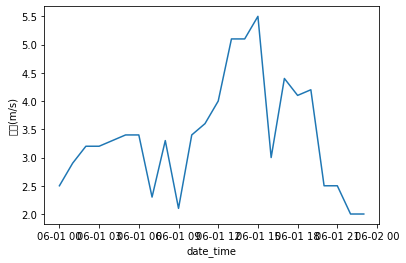

In [56]:
sns.lineplot(data = num_1_j_1, x = 'date_time', y = '풍속(m/s)')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)


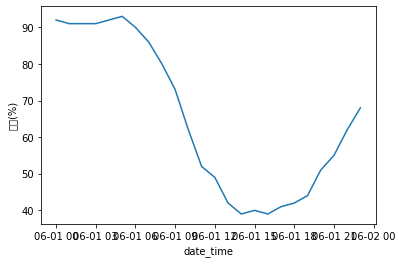

In [57]:
sns.lineplot(data = num_1_j_1, x = 'date_time', y = '습도(%)')

In [58]:
#기온 결측치 채우기
test['기온(°C)'] = test['기온(°C)'].interpolate(method='quadratic')
#마지막 na 채우기
test['기온(°C)'] = test['기온(°C)'].interpolate(method='linear')

#풍속 결측치 채우기
test['풍속(m/s)'] = test['풍속(m/s)'].interpolate(method='linear')

#습도 결측치 채우기
test['습도(%)'] = test['습도(%)'].interpolate(method='quadratic')
#마지막 na 채우기
test['습도(%)'] = test['습도(%)'].interpolate(method='linear')

#강수량 결측치 채우기
test['강수량(mm, 6시간)'] = test['강수량(mm, 6시간)'].interpolate(method='linear')

In [59]:
train['불쾌지수'] = 1.8*train['기온(°C)'] - 0.55*(1-(train['습도(%)']/100))*(1.8*train['기온(°C)']-26) + 32
test['불쾌지수'] = 1.8*test['기온(°C)'] - 0.55*(1-(test['습도(%)']/100))*(1.8*test['기온(°C)']-26) + 32

# (데이터프레임 변수 순서 정리)
train = train[['num','date_time','month', 'day', 'hour','weekday','weekend','기온(°C)','습도(%)','불쾌지수','풍속(m/s)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','전력사용량(kWh)']]
test = test[['num','date_time','month', 'day', 'hour','weekday','weekend','기온(°C)','습도(%)','불쾌지수','풍속(m/s)','강수량(mm, 6시간)','일조(hr, 3시간)','비전기냉방설비운영','태양광보유']]

# Modeling

## 1) LGBM

In [60]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

In [63]:
train_x=train.drop('전력사용량(kWh)', axis=1)
train_y=train[['전력사용량(kWh)']]


train_x.drop('date_time', axis=1, inplace=True)
test.drop('date_time', axis=1, inplace=True)


cross=KFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in cross.split(train_x, train_y):
    folds.append((train_idx, valid_idx))

In [65]:
## ref : https://www.dacon.io/competitions/official/235713/codeshare/2476?page=1&dtype=recent

models={}
for fold in range(5):
    print(f'===================={fold+1}=======================')

    start = time.time()

    train_idx, valid_idx=folds[fold]
    X_train=train_x.iloc[train_idx, :]
    y_train=train_y.iloc[train_idx, :]
    X_valid=train_x.iloc[valid_idx, :]
    y_valid=train_y.iloc[valid_idx, :]
    
    model=LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
             early_stopping_rounds=30, verbose=100)
    models[fold]=model
    
    print('')
    print((time.time() - start) / 60 , 'mins')
    print(f'================================================\n\n')


====================1=======================
Training until validation scores don't improve for 30 rounds.
[100]	training's l2: 94199.2	valid_1's l2: 93428.1
Did not meet early stopping. Best iteration is:
[100]	training's l2: 94199.2	valid_1's l2: 93428.1

0.016114433606465656 mins


====================2=======================
Training until validation scores don't improve for 30 rounds.
[100]	training's l2: 93010.8	valid_1's l2: 103767
Did not meet early stopping. Best iteration is:
[100]	training's l2: 93010.8	valid_1's l2: 103767

0.01645661195119222 mins


====================3=======================
Training until validation scores don't improve for 30 rounds.
[100]	training's l2: 94955.6	valid_1's l2: 94857.2
Did not meet early stopping. Best iteration is:
[100]	training's l2: 94955.6	valid_1's l2: 94857.2

0.016076159477233887 mins


====================4=======================
Training until validation scores don't improve for 30 rounds.
[100]	training's l2: 93043.2	valid_1's

In [66]:
for i in range(5):
    submission['answer'] += models[i].predict(test)/5 

In [67]:
submission.head()

,num_date_time,answer
0,1 2020-08-25 00,8594.988779
1,1 2020-08-25 01,8550.739670
2,1 2020-08-25 02,8538.556972
3,1 2020-08-25 03,8549.776655
4,1 2020-08-25 04,8545.885604


In [68]:
submission.to_csv('baseline_submission3_lgbm.csv', index=False)

## 2) LSTM

In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN

tf.keras.backend.set_floatx('float64')
